In [2]:
import arviz as az
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
data = pd.read_csv("./data/flats.csv", index_col=0)

In [4]:
# Посмотрим тип данных, структуру и статистики
display(
    data.head(), 
    data.info(), 
    data.describe(), 
    data.shape, 
)

<class 'pandas.core.frame.DataFrame'>
Index: 6042 entries, 8056 to 30470
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_doc  6042 non-null   int64  
 1   full_sq    6042 non-null   int64  
 2   life_sq    6042 non-null   float64
 3   num_room   6042 non-null   float64
 4   kitch_sq   6042 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 283.2 KB


,price_doc,full_sq,life_sq,num_room,kitch_sq
8056,2750000,11,11.0,1.0,12.0
8154,7100000,45,27.0,2.0,6.0
8287,11700000,77,50.0,3.0,8.0
8387,10400000,56,29.0,2.0,10.0
8391,6200000,31,21.0,1.0,5.0


None

,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,9.512250e+07,637.000000,637.000000,17.000000,96.000000


(6042, 5)

> Обратим внимание на наличие квартир с около нулевой площадью, отметим данный факт как возможность почистить выбросы

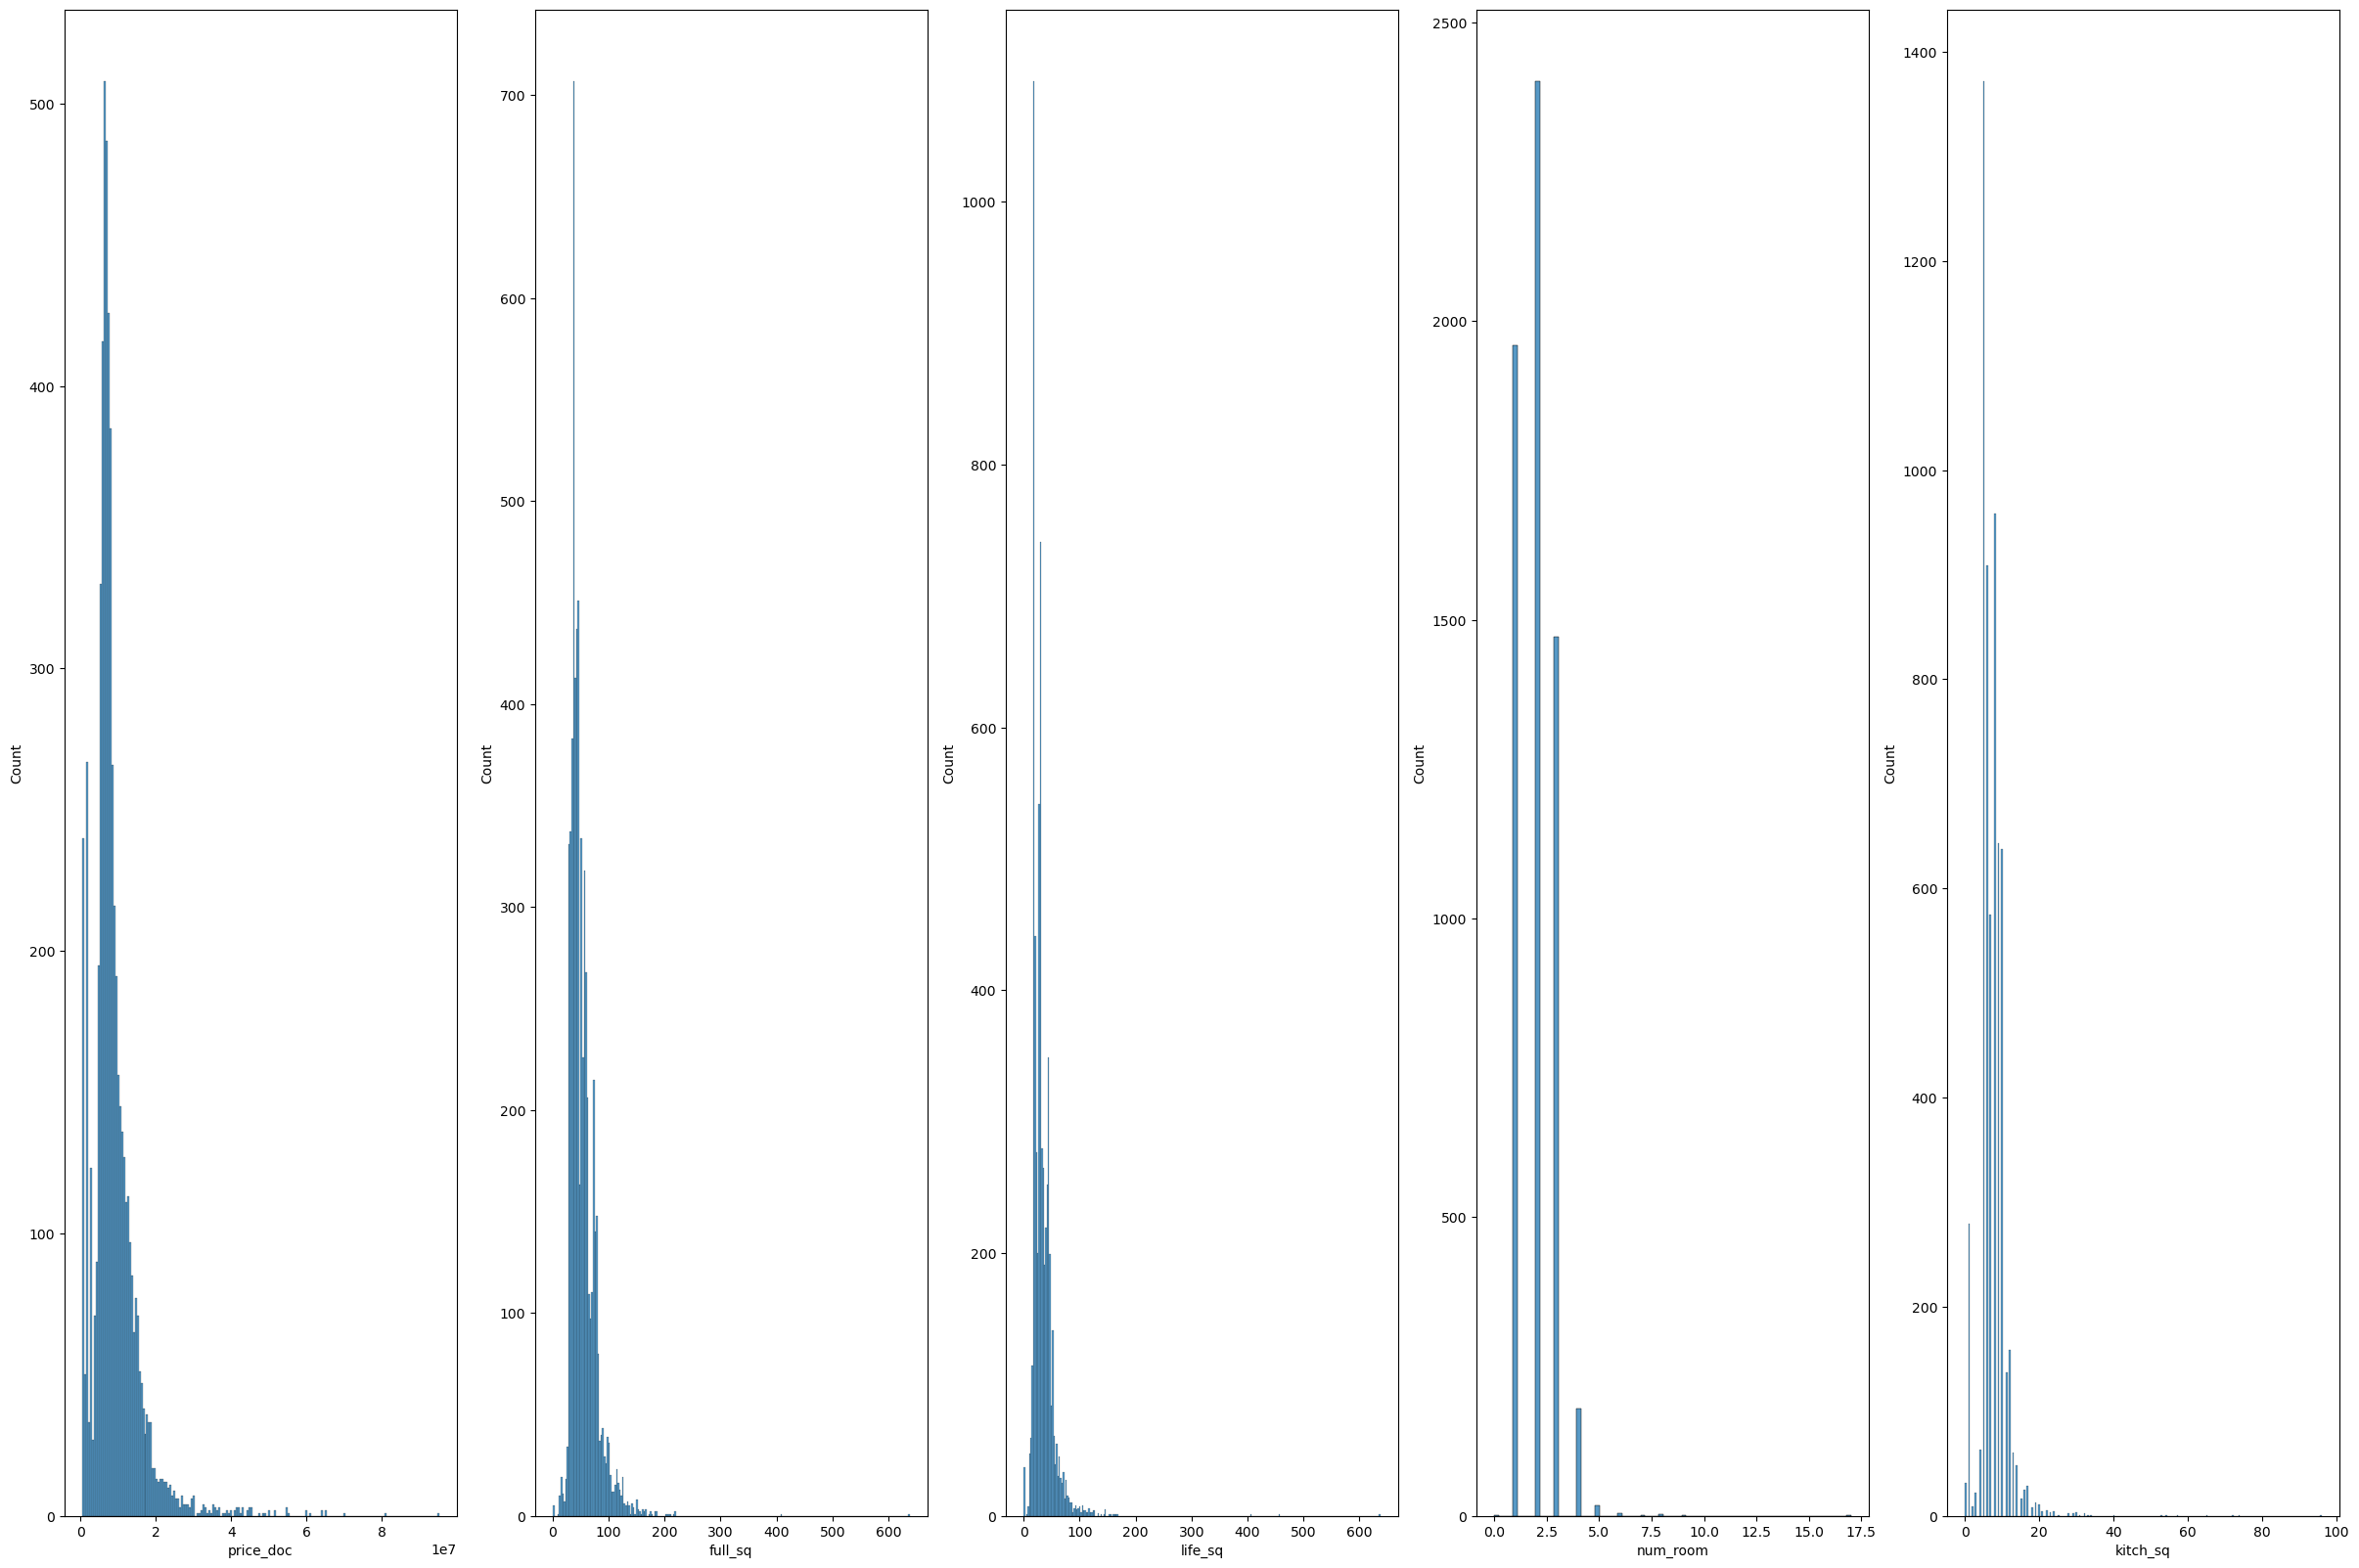

In [5]:
# Посмотрим распределения
f, ax = plt.subplots(1, 5, figsize=(30,20))
for i,j in enumerate(data.columns.to_list()):
    sns.histplot(data[j], ax=ax[i])

> Для всех признаков характерно скорее логнормальное распределение, за исключением признака площади кухни

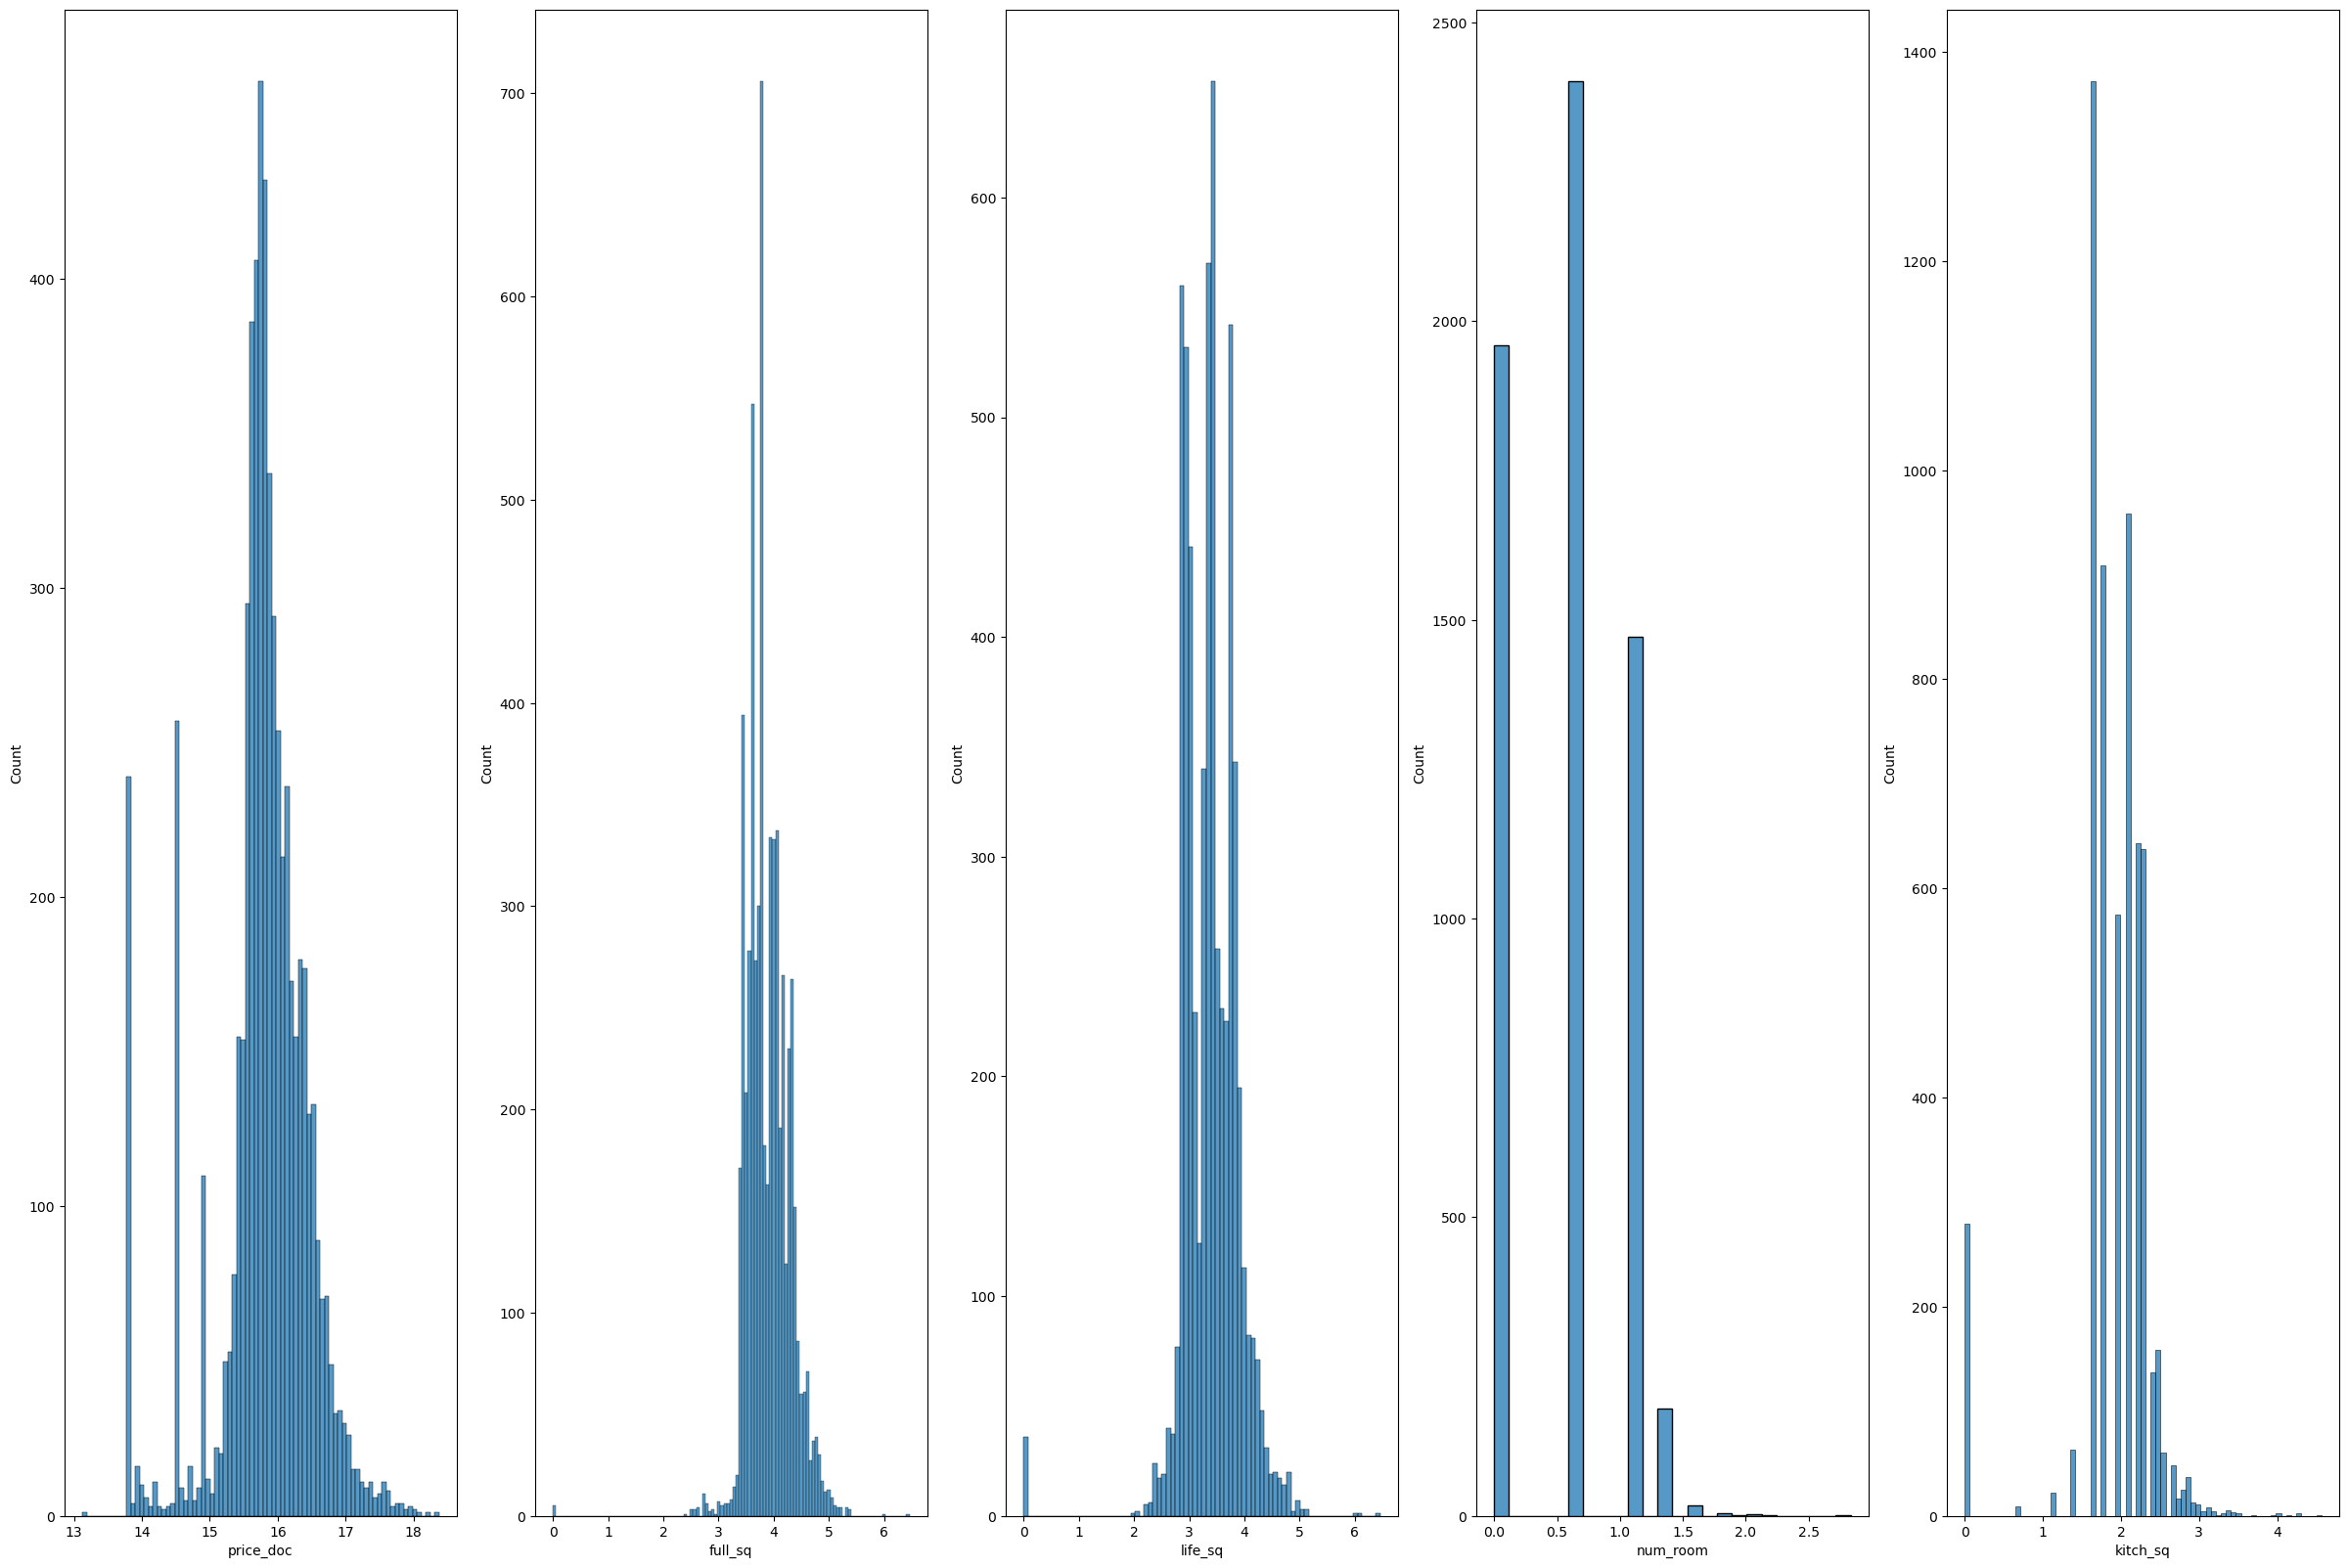

In [6]:
# Посмотрим распределения на копии датафрейма для понимания того
f, ax = plt.subplots(1, 5, figsize=(30,20))

data_log = data.copy()

for i,j in enumerate(data.columns.to_list()):
    data_log[j] = data[j].apply(np.log)
    sns.histplot(data_log[j], ax=ax[i])


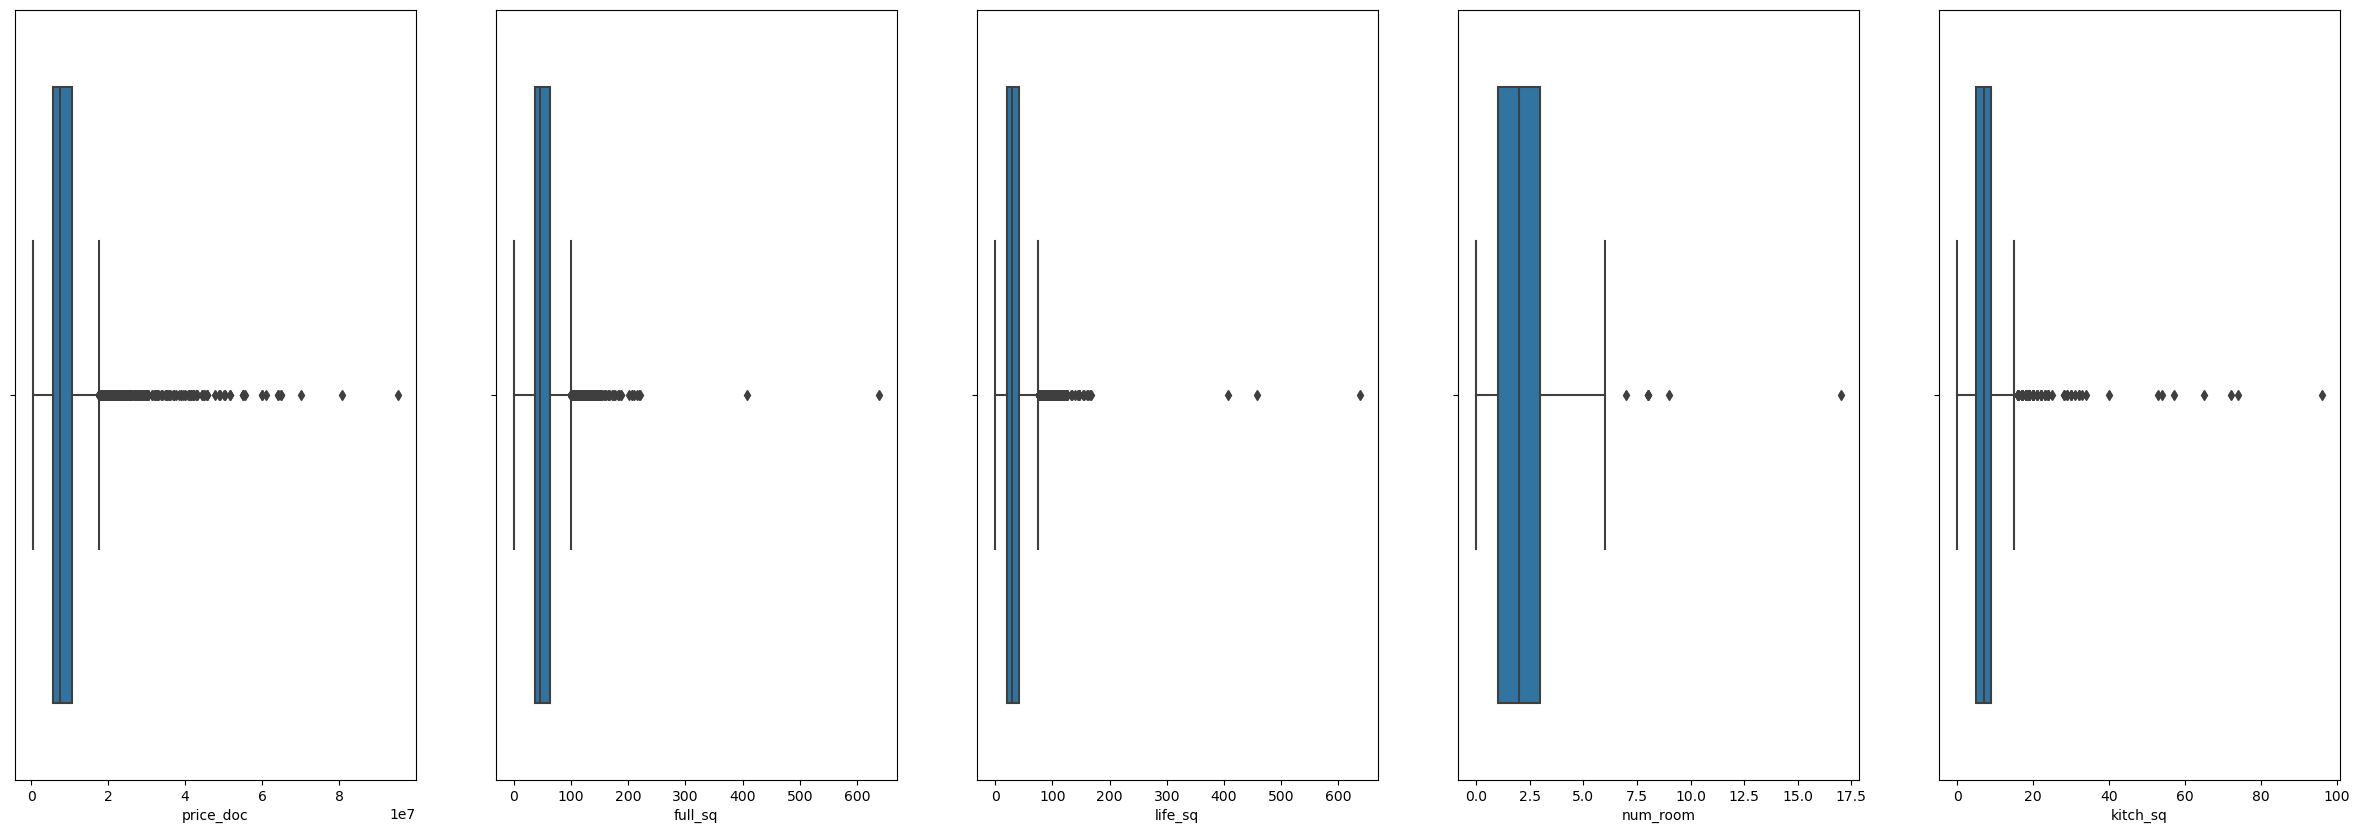

In [7]:
# Посмотрим вероятные выбросы выбросы
f, ax = plt.subplots(1, 5, figsize=(30,10))

for i, j in enumerate(data.columns.to_list()):
    sns.boxplot(data=data, x=j, ax=ax[i])

> В данном случае сложно называть выбросами аномальные значения на боксплоте, ввиду характера информации, в нашем случае аномальными значениями будут скорее те, что идут против логики, это мы рассмотрим ниже.

----
### Сначала очистим датасет от вероятно ошибочных данных, идущих вразрез с логикой

In [8]:
# Посмотрим на квартиры с обшей площадью == 1
exc_1 = data["full_sq"] <= 1
data[exc_1]

,price_doc,full_sq,life_sq,num_room,kitch_sq
17194,13066000,1,1.0,1.0,1.0
18600,6675730,1,1.0,1.0,1.0
22412,14923206,1,47.0,1.0,1.0
23228,13452318,1,1.0,1.0,1.0
24892,17035200,1,1.0,1.0,1.0


In [9]:
# Очистим
data = data[~exc_1]

In [10]:
# Посмотрим на квартиры с обшей площадью < жилплощадью
exc_2 = data["full_sq"] < data["life_sq"]
data[exc_2]

,price_doc,full_sq,life_sq,num_room,kitch_sq
9256,13750000,77,458.0,3.0,10.0
29302,11000000,56,57.0,3.0,5.0


In [11]:
# Очистим
data = data[~exc_2]

In [12]:
# Посмотрим на квартиры с обшей площадью < площадь кухни
exc_3 = data["full_sq"] < data["kitch_sq"]
data[exc_3]


,price_doc,full_sq,life_sq,num_room,kitch_sq
8056,2750000,11,11.0,1.0,12.0


In [13]:
# Очистим
data = data[~exc_3]

In [14]:
# Глянем статистики
data.describe()

,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6.034000e+03,6034.000000,6034.000000,6034.000000,6034.000000
mean,8.746670e+06,53.420617,33.147332,1.997680,7.395592
std,6.278575e+06,23.972298,19.425966,0.889369,3.803536
min,5.000000e+05,12.000000,0.000000,0.000000,0.000000
25%,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,9.512250e+07,637.000000,637.000000,17.000000,96.000000


---

### Проверим корреляцию признаков между собой и таргетом

,price_doc,full_sq,life_sq,num_room,kitch_sq
price_doc,1.000000,0.678149,0.543256,0.479230,0.370099
full_sq,0.678149,1.000000,0.886612,0.677535,0.401006
life_sq,0.543256,0.886612,1.000000,0.601423,0.206425
num_room,0.479230,0.677535,0.601423,1.000000,0.180641
kitch_sq,0.370099,0.401006,0.206425,0.180641,1.000000


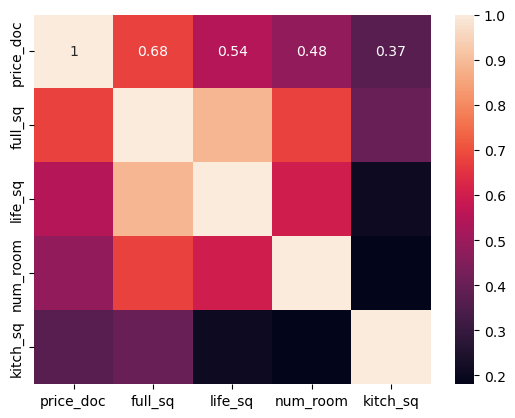

In [15]:
sns.heatmap(data.corr(), annot=True)
display(data.corr())

> Мы видим: 
> 1. Наличие сильной связи между таргетом и общей площадью, а так же средней корреляцией с жилой.
> 2. Наличие достаточно слабой связи с количеством комнат и размером кухни.
> 3. Наличие мультиколлинеарности между фитами.
> Как итог попробуем использовать для моделирование только фит full_sq

----
### Подготовим выборки

In [16]:
X = np.array(data["full_sq"]).reshape(-1, 1)
y = data["price_doc"]
#y = np.array(data["price_doc"]).reshape(-1, 1)

# Разобьем данные на трейн тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Нормируем данные
scaller = StandardScaler()
X_train_scaled = scaller.fit_transform(X_train)
X_test_scaled = scaller.transform(X_test)

display(X_train_scaled.shape, X_test_scaled.shape)

(4827, 1)

(1207, 1)

### Строим модель байесовской линейной регрессии

In [17]:
with pm.Model() as model:
    # Коэфициенты линейной регрессии
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X_train_scaled.shape[1])

    # Модель линейной регрессии
    mu = alpha + pm.math.dot(X_train_scaled, beta)

    # Правдобие
    likelihood = pm.Normal("likelihood", mu=mu, sigma=1, observed=y_train)

    # Байесовский вывод
    trace = pm.sample(1000, random_seed=42, tune=1000)

    # Апостериорное предсказание
    post_pred = pm.sample_posterior_predictive(trace=trace)
   
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [likelihood]


In [46]:
# Создание предсказаний на тестовых данных
alpha_pred = np.array(trace.posterior["alpha"].mean())
beta_pred = np.array(trace.posterior["beta"].mean())
    
predictions = alpha_pred + np.dot(X_test_scaled, beta_pred)